In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf

import tensorflow_datasets as tfds
import os

2022-03-13 12:45:25.929415: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-13 12:45:25.929774: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
DATASETS_DIR = "/home/transformer/learning-datasets"
TRAIN_DATASETS_DIR = os.path.join(DATASETS_DIR, "training")
TEST_DATASETS_DIR = os.path.join(DATASETS_DIR, "testing")
FILENAME = ["good.txt","bad.txt"]

In [4]:
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

train_data_sets = []
test_data_sets = []

for i, file_name in enumerate(FILENAME):
    lines_dataset = tf.data.TextLineDataset(os.path.join(TRAIN_DATASETS_DIR, file_name))
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    train_data_sets.append(labeled_dataset)

for i, file_name in enumerate(FILENAME):
    lines_dataset = tf.data.TextLineDataset(os.path.join(TEST_DATASETS_DIR, file_name))
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    test_data_sets.append(labeled_dataset)

2022-03-13 12:45:32.094638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-13 12:45:32.094875: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-13 12:45:32.094943: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-4VN4G0C): /proc/driver/nvidia/version does not exist
2022-03-13 12:45:32.095906: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64

In [6]:
train_data = train_data_sets[0]
for labeled_dataset in train_data_sets[1:]:
  train_data = train_data.concatenate(labeled_dataset)

test_data = test_data_sets[0]
for labeled_dataset in test_data_sets[1:]:
    test_data = test_data.concatenate(labeled_dataset)

train_data = train_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)
test_data = test_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False
)

In [7]:
for ex in train_data.take(5):
  print(ex)

for ex in test_data.take(5):
    print(ex)

(<tf.Tensor: shape=(), dtype=string, numpy=b'powhatan_gifts'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'64356135653039353435386639306230'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'bosn2230'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'a791219'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'index.php txt http   cirt.net rfiinc.txt'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'dda2qr7j.exe  script cross_site_scripting.nasl  script '>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'2451740'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'145392'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'meta http-equiv set-cookie content

In [8]:
train_dataset = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [9]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

2022-03-13 12:45:50.511944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 22644 of 50000


texts:  [b'phpmyadmin main.php g2_itemid .. .. .. .. .. license\\x00' b'x " %";'
 b'main.php stuff "&ver, q93432438&rem,']

labels:  [1 1 1]


2022-03-13 12:45:53.711968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


In [10]:
VOCAB_SIZE = 50000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

2022-03-13 12:46:04.645745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 26551 of 50000
2022-03-13 12:46:07.334710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


In [11]:
import numpy as np
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'script', 'javascript', 'etc', 'examples', 'src',
       'jsp', 'img', 'scripts', 'http', 'content', 'meta', 'httpequiv',
       'documentcookie', 'setcookie', 'xxpathxx',
       'crosssitescriptingnasl', 'javascriptalertcrosssitescriptingnasl',
       'indexphp'], dtype='<U1030')

In [12]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[   39,    24,  1285,  1480,     0,     0,     0,     0,     0],
       [   30,     0,     0,     0,     0,     0,     0,     0,     0],
       [   24,    22,    97, 25684,     0,     0,     0,     0,     0]])

In [13]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'phpmyadmin main.php g2_itemid .. .. .. .. .. license\\x00'
Round-trip:  phpmyadmin mainphp g2itemid licensex00     

Original:  b'x " %";'
Round-trip:  x        

Original:  b'main.php stuff "&ver, q93432438&rem,'
Round-trip:  mainphp stuff ver q93432438rem     



In [14]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          3200000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,274,369
Trainable params: 3,274,369
Non-

In [15]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [16]:
# predict on a sample text without padding.

sample_text = ("top.php stuff 'uname >q36497765 #")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.01584047]


In [17]:
# predict on a sample text with padding

padding = "../../" * 20
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.01584047]


In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [19]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


2022-03-13 12:47:16.808719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 17392 of 50000
2022-03-13 12:47:20.581369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


   1496/Unknown - 159s 75ms/step - loss: 0.4390 - accuracy: 0.8011WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 30 batches). You may need to use the repeat() function when building your dataset.
1497/1497 [==============================] - 171s 83ms/step - loss: 0.4390 - accuracy: 0.8011 - val_loss: 0.2614 - val_accuracy: 0.9480
Epoch 2/10


2022-03-13 12:49:35.645622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 21191 of 50000


   1/1497 [..............................] - ETA: 5:51:23 - loss: 0.3362 - accuracy: 0.8906

2022-03-13 12:49:39.593626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1497/1497 [==============================] - 107s 62ms/step - loss: 0.3201 - accuracy: 0.8535
Epoch 3/10
1497/1497 [==============================] - 101s 64ms/step - loss: 0.2403 - accuracy: 0.8846
Epoch 4/10
1497/1497 [==============================] - 122s 78ms/step - loss: 0.1888 - accuracy: 0.9100
Epoch 5/10
1497/1497 [==============================] - 111s 67ms/step - loss: 0.1728 - accuracy: 0.9162
Epoch 6/10


2022-03-13 12:56:56.596831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 18818 of 50000


   2/1497 [..............................] - ETA: 2:12 - loss: 0.1696 - accuracy: 0.9219   

2022-03-13 12:57:01.198477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1497/1497 [==============================] - 119s 70ms/step - loss: 0.1682 - accuracy: 0.9170
Epoch 7/10
1497/1497 [==============================] - 105s 66ms/step - loss: 0.1666 - accuracy: 0.9173
Epoch 8/10
1497/1497 [==============================] - 106s 67ms/step - loss: 0.1654 - accuracy: 0.9173
Epoch 9/10
1497/1497 [==============================] - 106s 67ms/step - loss: 0.1645 - accuracy: 0.9175
Epoch 10/10
1497/1497 [==============================] - 111s 69ms/step - loss: 0.1643 - accuracy: 0.9175


In [20]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 1s 46ms/step - loss: 0.4212 - accuracy: 0.9380
Test Loss: 0.4211770296096802
Test Accuracy: 0.9380000233650208


(0.0, 0.45275428146123886)

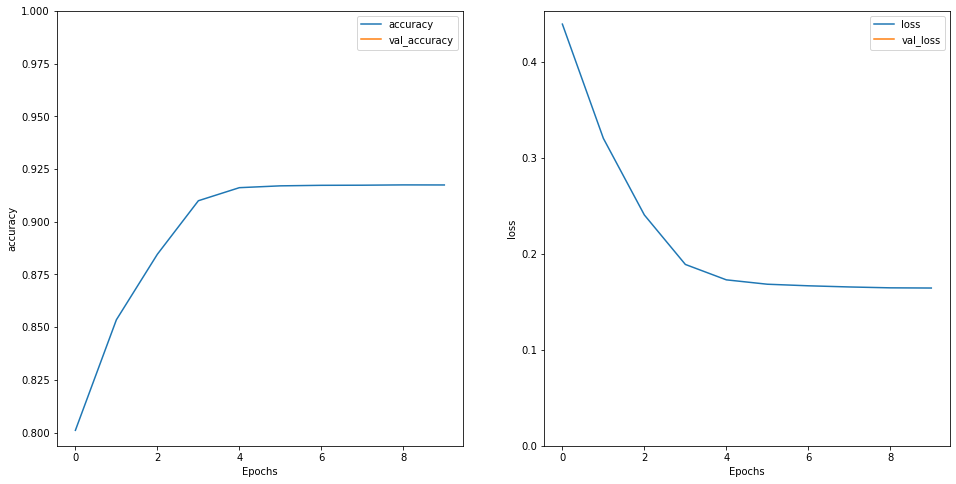

In [21]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [22]:
sample_text = ("script alert(1) script")
predictions = model.predict(np.array([sample_text]))
predictions

array([[56.204975]], dtype=float32)

In [23]:
!rm -rf /kaggle/working/*

In [24]:
model_save_path = "./my_model"
model.save(model_save_path, include_optimizer=False)

2022-03-13 13:06:51.803037: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./my_model/assets


INFO:tensorflow:Assets written to: ./my_model/assets


In [25]:
reloaded_model = tf.saved_model.load(model_save_path)

2022-03-13 13:08:03.858372: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-03-13 13:08:04.761574: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-03-13 13:08:09.606863: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-03-13 13:08:11.092406: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-03-13 13:08:12.701999: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_sh

In [26]:
sample_text = "script alert(1) script"
reloaded_model(np.array([sample_text]))[0]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([56.204975], dtype=float32)>

Tensorflow Serve